In [38]:
import sys

import matplotlib.pyplot as plt
import torch
from iopath.common.file_io import PathManager
from iopath.fb.manifold import ManifoldPathHandler
import logging

from iopath.fb.manifold import logger as manifold_logger
manifold_logger.setLevel(logging.WARN) # You need this!

pathmgr = PathManager()
pathmgr.register_handler(ManifoldPathHandler())
from tqdm import tqdm


sys.path.insert(0, "fbcode/ar_sharing/body_tracking_3d/models/hmr/")

pathmgr = PathManager()
pathmgr.register_handler(ManifoldPathHandler(), allow_override=True)

%load_ext autoreload
%autoreload 2

I1005 005451.237 parsh_logger.py:29] %autoreload 2 was called with 


The python.parsh.autoreload.autoreload extension is already loaded. To reload it, use:
  %reload_ext python.parsh.autoreload.autoreload


In [171]:
import src
from src.utils.plot_utils_experiment_check import plot_mpjpes_and_accel, plot_heatmap

In [187]:
import numpy as np

### fix cons==0.5, f30
common_path = "manifold://xr_body/tree/personal/andreydavydov/my_exps/"
ckpt_names = {}

weights = [0.0, 1e-3, 3e-3, 1e-2, 3e-2, 1e-1, 3e-1, 1, 3, 10, 30, 100, 300]
flow_smooth_grid_accel = np.zeros((len(weights), len(weights)))
flow_smooth_grid_mpjpe = np.zeros((len(weights), len(weights)))

for i, flow_weight in enumerate(weights):
    for j, smooth_weight in enumerate(weights):
        if flow_weight == 0 and smooth_weight == 0:
            flow_smooth_grid_mpjpe[i, j] = 57.4
            flow_smooth_grid_accel[i, j] = 16.5
            continue

        exp_name = f"seq_optim_flow__temp_smooth/seq_optim__coco-all__3dpw_test_seq_339__grid_flow2d_{flow_weight}_smooth_{smooth_weight}"
        exp_path = f"{common_path}/{exp_name}"
        ckpt_names["f/s" + f" {flow_weight}/{smooth_weight}"] = exp_name

        pa_mpjpe_path = pathmgr.get_local_path(f"{exp_path}/metrics/pa_mpjpe_vs_gt_valid.pth")
        pa_mpjpe = np.array(torch.load(pa_mpjpe_path, map_location="cpu")["prev_vals"])
        flow_smooth_grid_mpjpe[i, j] = pa_mpjpe[-1]

        accel_error_path = pathmgr.get_local_path(f"{exp_path}/metrics/accel_err_vs_gt_valid.pth")
        accel_error = np.array(torch.load(accel_error_path, map_location="cpu")["prev_vals"])
        flow_smooth_grid_accel[i, j] = accel_error[-1]

In [212]:
d = dict(zip(weights, np.arange(len(weights))))
print(
    flow_smooth_grid_mpjpe[d[0.001], d[3]],
    flow_smooth_grid_mpjpe[d[0.003], d[10]],
    flow_smooth_grid_mpjpe[d[0.01], d[30]],
    flow_smooth_grid_mpjpe[d[0.03], d[100]],
)

print(
    flow_smooth_grid_accel[d[0.001], d[3]],
    flow_smooth_grid_accel[d[0.003], d[10]],
    flow_smooth_grid_accel[d[0.01], d[30]],
    flow_smooth_grid_accel[d[0.03], d[100]],
)

56.7095947265625 56.71608352661133 56.71086502075195 56.71683120727539
5.241035461425781 5.235584735870361 5.24052095413208 5.237612247467041


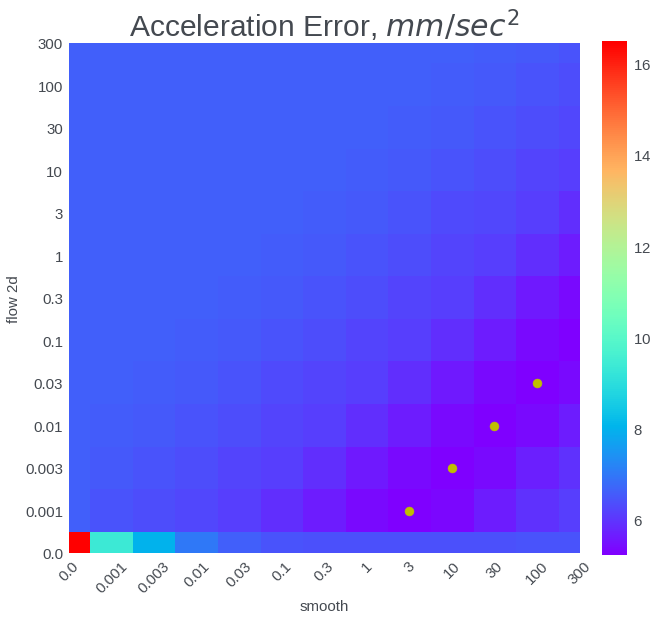

In [231]:
fig, ax = plot_heatmap(
    flow_smooth_grid_accel,
    weights,
    weights,
    "flow 2d",
    "smooth",
    title=r"Acceleration Error, $mm/sec^2$",
)
ax.scatter([d[3], d[10], d[30], d[100]], [d[0.001], d[0.003], d[0.01], d[0.03]], s=80, c='y')

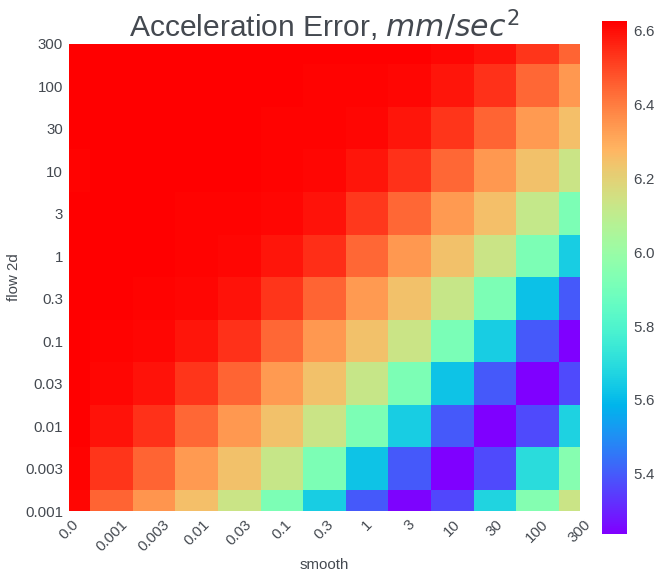

In [222]:
fig, ax = plot_heatmap(
    flow_smooth_grid_accel[1:],
    weights[1:],
    weights,
    "flow 2d",
    "smooth",
    title=r"Acceleration Error, $mm/sec^2$",
)

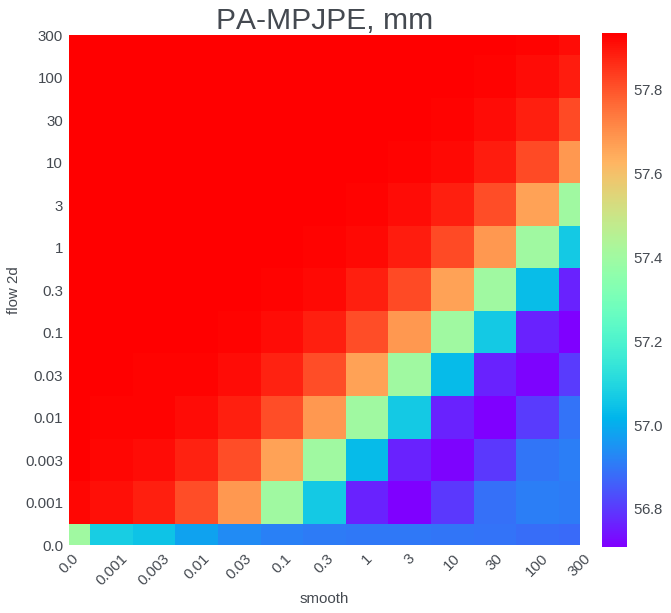

In [223]:
fig, ax = plot_heatmap(
    flow_smooth_grid_mpjpe,
    weights,
    weights,
    "flow 2d",
    "smooth",
    title="PA-MPJPE, mm")

56.7095947265625 56.71608352661133 56.71086502075195 56.71683120727539
5.241035461425781 5.235584735870361 5.24052095413208 5.237612247467041


In [165]:
print(np.min(flow_smooth_grid_mpjpe), np.max(flow_smooth_grid_mpjpe))
print(np.min(flow_smooth_grid_accel), np.max(flow_smooth_grid_accel))

56.7095947265625 57.93424987792969
5.235584735870361 16.5


Reloading changes to ['src.utils.plot_utils_experiment_check']


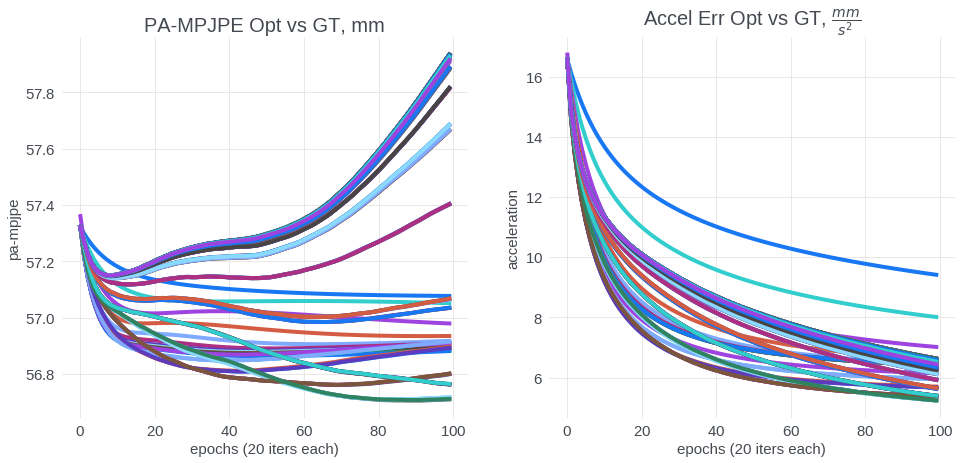

In [208]:
fig = plot_mpjpes_and_accel(ckpt_names, force=False)

# write videos

In [281]:
from src.functional import smpl
from src.utils.video_utils import write_video

device = "cuda:0"
smpl_model = smpl.get_smpl_model("h36m", device=device)
fps = 30
batch_size = 339
num_frames = 300
img_size = torch.tensor([224, 224]).repeat(batch_size, 1).to(device)
faces = smpl_model.faces.astype(int)

import os

video_dir = "/tmp/videos_grid_flow2d_smooth/"
os.makedirs(video_dir, exist_ok=True)

import numpy as np


def render_verts_only(verts, faces, device, img_size=512):
    verts_mean = verts.copy().mean(axis=0, keepdims=True)
    verts -= verts_mean
    scale = 1  # 0.8
    verts *= scale
    verts = (verts + 1) / 2 * img_size
    # img = np.zeros((img_size,img_size,3))
    img = (255 * np.ones((img_size, img_size, 3))).astype("uint8")
    blend = render_mesh_onto_image(img, verts, faces, device)
    return blend

In [284]:
from src.datasets.datasets_common import UNNORMALIZE

seq = "downtown_runForBus_01_0"
f_name = f"sample_3dpw_test_seq_{seq}__hmr_coco_all.pth"
remote_path = f"manifold://xr_body/tree/personal/andreydavydov/3dpw_seq_for_tests/{f_name}"

seq = torch.load(pathmgr.get_local_path(remote_path))

for k in seq:
    seq[k] = seq[k][:batch_size]

img_orig = UNNORMALIZE(seq["img"]).permute(0, 2, 3, 1).numpy().astype("uint8")
img_orig = img_orig[-num_frames:]

write_video(img_orig, f"{video_dir}orig.mp4", fps=fps)

from src.models.seq_optim import get_smpl_out
from src.utils.img_utils import convert_norm_points_to_bbox
from src.utils.vis_utils import render_mesh_onto_image

rotmat_init = seq["pred_rotmat"].to(device)
shape_init = seq["pred_shape"].to(device)
camera_init = seq["pred_camera"].to(device)

_, _, verts_all = get_smpl_out(shape_init, rotmat_init, camera_init, smpl_model, pose2rot=False)
scale, trans = camera_init[:, 0], camera_init[:, 1:]
verts_all_bbox = convert_norm_points_to_bbox(verts_all, scale, trans, img_size)

verts_all = verts_all.cpu().numpy()[-num_frames:]
verts_all_bbox = verts_all_bbox.cpu().numpy()[-num_frames:]

l, r = 50, 50
frames_out = []
for img, verts in zip(img_orig, verts_all_bbox):
    blend = render_mesh_onto_image(img, verts, faces, device)[:,l:-r]
    frames_out.append(blend)

write_video(frames_out, f"{video_dir}pred_hmr.mp4", fps=fps)

l, r = 100, 100 # orig size is 512 x 512
frames_out = []
for img, verts in zip(img_orig, verts_all):
    blend = render_verts_only(verts, faces, device)[:, l:-r]
    frames_out.append(blend)

write_video(frames_out, f"{video_dir}verts_pred_hmr.mp4", fps=fps)

Video is saved to '/tmp/videos_grid_flow2d_smooth/orig.mp4'


/data/sandcastle/boxes/fbsource/buck-out/v2/gen/fbcode/110b607930331a92/ar_sharing/body_tracking_3d/models/hmr/__bento_kernel_body_tracking__/bento_kernel_body_tracking#link-tree/pytorch3d/renderer/mesh/textures.py:324: PendingDeprecationWarning:

Textures class is deprecated,
        use TexturesUV, TexturesAtlas, TexturesVertex instead.
        Textures class will be removed in future releases.



Video is saved to '/tmp/videos_grid_flow2d_smooth/pred_hmr.mp4'


Video is saved to '/tmp/videos_grid_flow2d_smooth/verts_pred_hmr.mp4'


In [286]:
ckpt_names = {
    "flow2d": "manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_flow/seq_optim__coco-all__3dpw_test_seq_339__flow2d__shorter_epochs/ckpt.pth",
    "smoothing": "manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_grid_shape_pose/grid__shape_1_pose_1_f30/ckpt.pth",
    "flow2d + smoothing": "manifold://xr_body/tree/personal/andreydavydov/my_exps/seq_optim_flow__temp_smooth/seq_optim__coco-all__3dpw_test_seq_339__grid_flow2d_0.001_smooth_3/ckpt.pth",
}

for name, ckpt_path in ckpt_names.items():
    ckpt = torch.load(pathmgr.get_local_path(ckpt_path), map_location="cpu")["seqOpt_state_dict"]

    pose = ckpt["pose"].to(device)
    shape = ckpt["shape"].to(device)
    camera = ckpt["camera"].to(device)

    _, _, verts_all = get_smpl_out(shape, pose, camera, smpl_model, pose2rot=True)
    scale, trans = camera[:, 0], camera[:, 1:]
    verts_all_bbox = convert_norm_points_to_bbox(verts_all, scale, trans, img_size)

    verts_all = verts_all.cpu().numpy()[-num_frames:]
    verts_all_bbox = verts_all_bbox.cpu().numpy()[-num_frames:]

    l, r = 50, 50
    frames_out = []
    for img, verts in zip(img_orig, verts_all_bbox):
        blend = render_mesh_onto_image(img, verts, faces, device)[:, l:-r]
        frames_out.append(blend)

    write_video(frames_out, f"{video_dir}Ours_{name}.mp4", fps=fps)


    l, r = 100, 100
    frames_out = []
    for img, verts in zip(img_orig, verts_all):
        blend = render_verts_only(verts, faces, device)[:, l:-r]
        frames_out.append(blend)

    write_video(frames_out, f"{video_dir}verts_{name}.mp4", fps=fps)



Video is saved to '/tmp/videos_grid_flow2d_smooth/Ours_flow2d.mp4'


Video is saved to '/tmp/videos_grid_flow2d_smooth/verts_flow2d.mp4'


Video is saved to '/tmp/videos_grid_flow2d_smooth/Ours_smoothing.mp4'


Video is saved to '/tmp/videos_grid_flow2d_smooth/verts_smoothing.mp4'


Video is saved to '/tmp/videos_grid_flow2d_smooth/Ours_flow2d + smoothing.mp4'


Video is saved to '/tmp/videos_grid_flow2d_smooth/verts_flow2d + smoothing.mp4'


In [316]:
from src.utils.video_utils import get_frames


video_paths = [
    "/tmp/videos_grid_flow2d_smooth/verts_flow2d + smoothing.mp4",
    "/tmp/videos_grid_flow2d_smooth/verts_gt.mp4",
    "/tmp/videos_grid_flow2d_smooth/verts_tcmr_16.mp4",
]

vid_frames = []
for vid_path in video_paths:
    frame_list, _ = get_frames(pathmgr.get_local_path(vid_path))
    vid_frames.append(frame_list)

num_frames = len(frame_list)

In [313]:
out_frames = []
for frame_idx in range(num_frames):
    out_frame = np.concatenate((vid_frames[0][frame_idx], vid_frames[1][frame_idx], vid_frames[2][frame_idx]), axis=1)
    # out_frame1 = np.concatenate((vid_frames[0][frame_idx], vid_frames[1][frame_idx], 255*np.ones_like(vid_frames[1][frame_idx], dtype='uint8')), axis=1)
    # out_frame2 = np.concatenate((vid_frames[2][frame_idx], vid_frames[3][frame_idx], vid_frames[4][frame_idx]), axis=1)
    # out_frame = np.concatenate((out_frame1, out_frame2), axis=0)
    out_frames.append(out_frame)

out_path = "/tmp/videos_grid_flow2d_smooth/concat.mp4"
write_video(out_frames, out_path, fps=fps)

Video is saved to '/tmp/videos_grid_flow2d_smooth/concat.mp4'


In [ ]:
video_paths = [
    "/tmp/videos_grid_flow2d_smooth/Ours_flow2d + smoothing.mp4",
    "/tmp/videos_grid_flow2d_smooth/Ours_tcmr_16.mp4",
]

vid_frames = []
for vid_path in video_paths:
    frame_list, _ = get_frames(pathmgr.get_local_path(vid_path))
    vid_frames.append(frame_list)

num_frames = len(frame_list)

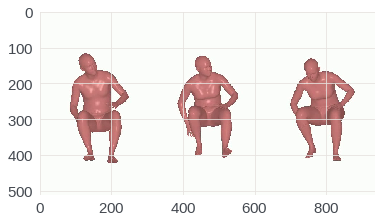

In [314]:
out_frames = []
for frame_idx in range(num_frames):
    out_frame = np.concatenate((vid_frames[0][frame_idx], vid_frames[1][frame_idx], vid_frames[2][frame_idx]), axis=1)
    # out_frame1 = np.concatenate((vid_frames[0][frame_idx], vid_frames[1][frame_idx], 255*np.ones_like(vid_frames[1][frame_idx], dtype='uint8')), axis=1)
    # out_frame2 = np.concatenate((vid_frames[2][frame_idx], vid_frames[3][frame_idx], vid_frames[4][frame_idx]), axis=1)
    # out_frame = np.concatenate((out_frame1, out_frame2), axis=0)
    out_frames.append(out_frame)

out_path = "/tmp/videos_grid_flow2d_smooth/concat.mp4"
write_video(out_frames, out_path, fps=fps)